# READ ME TO GET STARTED!

Hi everyone this is Daniel. I've written a lot of the infrastructure code so that we can do experiments quickly. The main idea is that all you have to do is write your own evaluation function (i.e. f: Board -> Scalar) and my code will handle the rest (game logic, minimax tree search, simulation, etc).

In order to try your own experiments for evaluation functions, simply follow the following procedure:

1. Initialize your board
2. Initialize your agents
3. Run your simulations!



I've implemented 2D and 3D TicTacToe boards as well as a `TicTacToe` object which can take in a board and 2 `Agent` objects. An `Agent` object will just take in a board state and spit out what it thinks the best move is -- in our experiments, we should be trying to make the *best possible agent* and verify it's the best by running simulations of agents playing against each other.

## Simple Example: Simulating random agents in 2D

### Step 0: Import things

In [1]:
from tictactoe import Board2D, TicTacToe # all tictactoe / gamelogic stuff is in tictactoe.py
from sim import simulate # sim.py is where the simulations lie
from agent import RandomAgent # whenever you finalize an agent, add it to agents.py!

import numpy as np

### Step 1: Define your board

In [2]:
board = Board2D(board_size=3) # this defines a 3x3 gameboard, i.e. the original gameboard

### Step 2: Define your agents

In [3]:
rand1 = RandomAgent(name='rand1') # we can name agents to differentiate between them
rand2 = RandomAgent(name='rand2')

### Step 3: Simulate!

This will run as many specified games of tictactoe with the defined agents and give you a dictionary of the results.

In [4]:
sim_results = simulate(board, rand1, rand2, num_sims=100)

In [5]:
sim_results

{'draw': 30, 'rand1': 38, 'rand2': 32}

As you can see, here are random results, as we'd expect. 

## Complex Example: Random behavior for nxn boards

One thing we might want to know is: how will this distribution change as the board size increases? Let's try this out with a bigger board.

In [6]:
import matplotlib.pyplot as plt
import collections
import seaborn as sns

In [7]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [8]:
new_board = Board2D(board_size=4)

In [9]:
sim_results = simulate(board, rand1, rand2, num_sims=100)

In [10]:
sim_results

{'draw': 36, 'rand1': 37, 'rand2': 27}

As you can see, there are a lot more draws in this one than before. Let's see how this behavior changes as we increase the board size even more.

In [11]:
results = []
dims = range(3, 10)
for size in dims:
    board = Board2D(board_size=size)
    results.append(simulate(board, rand1, rand2, num_sims=100))

In [12]:
results

[{'draw': 31, 'rand1': 32, 'rand2': 37},
 {'draw': 53, 'rand1': 19, 'rand2': 28},
 {'draw': 61, 'rand1': 20, 'rand2': 19},
 {'draw': 81, 'rand1': 7, 'rand2': 12},
 {'draw': 84, 'rand1': 8, 'rand2': 8},
 {'draw': 89, 'rand1': 5, 'rand2': 6},
 {'draw': 96, 'rand1': 3, 'rand2': 1}]

As the dimensions of our board increase, we can see the number of draws is drastically increasing. Let's plot these results.

In [13]:
sim_values = [list(x.values()) for x in results]
draws = [x[0]/sum(x) for x in sim_values] # get percentage
rand1_winrate = [x[1]/sum(x) for x in sim_values]
rand2_winrate = [x[2]/sum(x) for x in sim_values]

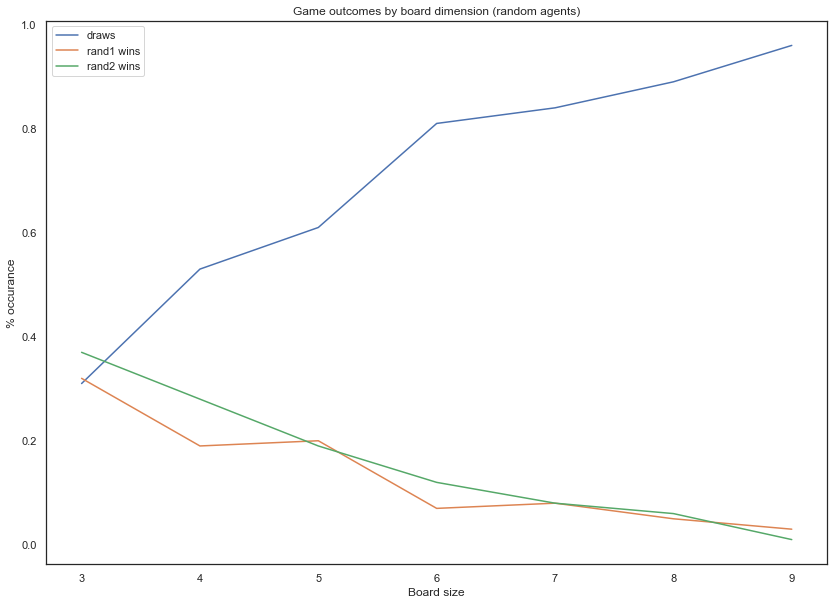

In [14]:
plt.plot(list(dims), draws, label='draws')
plt.plot(list(dims), rand1_winrate, label='rand1 wins')
plt.plot(list(dims), rand2_winrate, label='rand2 wins')
plt.title('Game outcomes by board dimension (random agents)')
plt.xlabel('Board size')
plt.ylabel('% occurance')
plt.legend()

### More Complex Example: implementing our own agent

The main thing you need to do to create your own agent is to define your own `evaluation` function. An evaluation function needs to take in a `Node` object (look at utils.py for class definition, it's just a useful abstraction for minimax) and spit out an evaluation (i.e. how good is this position?)

Let's walk through implementing a simple evaluation function and checking performance against a baseline (random agent).

In [15]:
from agent import MiniMaxAgent

In [16]:
def dist(loc1, loc2):
    return np.square(loc1 - loc2).sum()

def dist_from_center(loc, board):
    center = np.asarray([board.shape[0]//2, board.shape[1]//2])
    return dist(np.asarray(loc), center)

def my_eval_function(node, player):
    board = node.state
    score = 0
    # i.e. gets the player we're evaluating the perspective of
    my_pieces = zip(*np.where(board.board == player))
    for loc in my_pieces:
        score -= dist_from_center(loc, board.board)
    return score + np.random.normal()

The above evaluation function will make our agent value playing in the center of the board, i.e. it gets penalized the further it places pieces from the center. Let's see how this does against a random agent.

In [30]:
agent = MiniMaxAgent(my_eval_function, depth=1, name = 'MiniMaxAgent', using_ab_pruning = True)

Here we just defined a new `Agent` using the `MiniMaxAgent` class. In the definition we have to specify an *evaluation* function and a *depth*. The *depth* tells the agent *how far ahead should I look?* And the eval function tells the agent how to evaluate each position it simulates ahead to. In general, for 2d you should probably set depth to 5 or 6 at max, since the higher the depth the longer it takes to run the agent.

Let's simulate this agent against a random baseline just to compare.

In [37]:
agent = MiniMaxAgent(my_eval_function, depth=2, name = 'MiniMaxAgent', using_ab_pruning = True)
%timeit simulate(Board2D(board_size=3), rand1, agent, num_sims=400)

15.3 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
agent = MiniMaxAgent(my_eval_function, depth=2, name = 'MiniMaxAgent', using_ab_pruning = False)
%timeit simulate(Board2D(board_size=3), rand1, agent, num_sims=400)

18 s ± 56.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Clearly our agent is better than random! Let's see how this behavior generalizes for larger board sizes. Since this evaluation function gets slower with increasing board size, for the sake of running this in a reasonable amt of time we will plot less dimensions.

In [19]:
results = []
dims = range(3, 7)
for size in dims:
    board = Board2D(board_size=size)
    results.append(simulate(board, rand1, agent, num_sims=50))

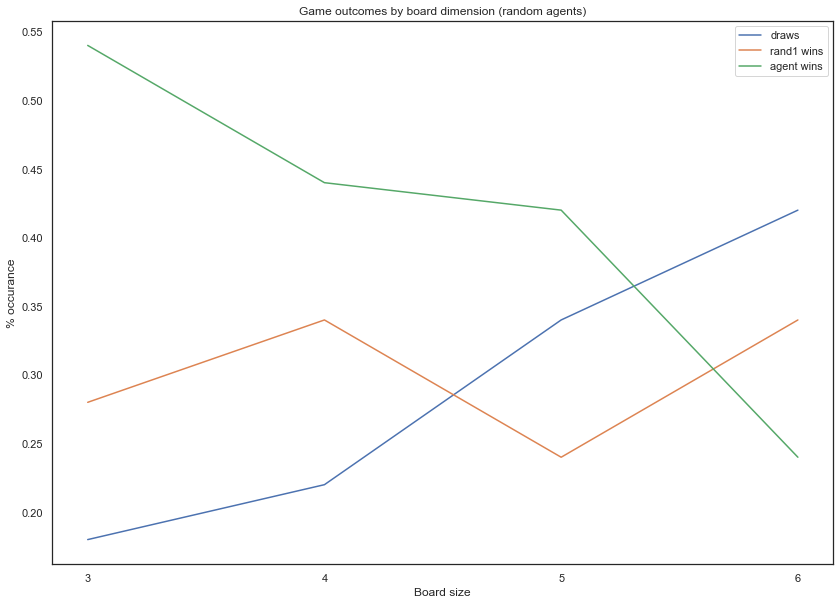

In [20]:
sim_values = [list(x.values()) for x in results]
draws = [x[0]/sum(x) for x in sim_values] # get percentage
rand1_winrate = [x[1]/sum(x) for x in sim_values]
agent_winrate = [x[2]/sum(x) for x in sim_values]

plt.plot(list(dims), draws, label='draws')
plt.plot(list(dims), rand1_winrate, label='rand1 wins')
plt.plot(list(dims), agent_winrate, label='agent wins')
plt.title('Game outcomes by board dimension (random agents)')
plt.xlabel('Board size')
plt.ylabel('% occurance')
plt.xticks(dims)
plt.legend()

As we can see, this agent (green line) does really well for smaller boards but when the board gets too big it turns out that going for the center might not be the best strategy.

## HOPEFULLY THIS WILL HELP YOU EXPERIMENT !! 
\- Daniel